In [ ]:
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import time
import torchvision as tv
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from torch.utils.data import Dataset
import os
from sklearn.neighbors import KNeighborsRegressor
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/Bone_Age_Datasets" "/content"

Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/Bone Age Datasets-selected': No such file or directory


In [ ]:
device = tc.device("cuda:0" if tc.cuda.is_available()else "cpu")
tc.cuda.device_count()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


0

In [ ]:
tc.cuda.get_device_name(0)

In [ ]:
tc.backends.cudnn.benchmark = True

## Dataset

Class -1 means male, 1 means female

In [ ]:
#read csv/xlsx files with age and sex data
xlsx_train = pd.read_csv('/content/Bone_Age_Datasets/Bone_Age_Train_Set/train.csv', index_col=0)
xlsx_train = xlsx_train.replace([True, False], [-1,1]).astype(float)
train_sex = xlsx_train["male"].to_dict()
train_age = xlsx_train["boneage"].to_dict()

xlsx_val1 = pd.read_csv('/content/Bone_Age_Datasets/Bone_Age_Validation_Set/validation.csv', index_col=0)
xlsx_val1 = xlsx_val1.replace([True, False], [-1,1]).astype(float)
val1_sex = xlsx_val1["male"].to_dict()
val1_age = xlsx_val1["Bone Age (months)"].to_dict()

xlsx_test = pd.read_excel('/content/Bone_Age_Datasets/Bone_Age_Test_Set/test.xlsx', index_col=0) 
xlsx_test = xlsx_test.replace(["M", "F"], [-1,1]).astype(float)
test_sex = xlsx_test["Sex"].to_dict() #.set_index("Case ID")
test_age = xlsx_test["Ground truth bone age (months)"].to_dict() #.set_index("Case ID")

NameError: ignored

In [ ]:
from torchvision.io import read_image

class ImageDataset(Dataset):
    def __init__(self, path_images, ages, sex, transform=None, target_transform=None):
        self.ages = ages
        self.sex = sex
        self.path_images = path_images
        self.transform = transform
        self.target_transform = target_transform
        
        self.image_id_list = [int(f[:-4]) for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))]

    def __len__(self):
        return len(self.image_id_list)

    def __getitem__(self, idx):
        image_id = self.image_id_list[idx]
        img_path = os.path.join(self.path_images, str(image_id)+".png")
        image = read_image(img_path) # mode=tv.io.ImageReadMode.RGB

        label = self.ages[image_id]
        sex = self.sex[image_id]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        #feature = tc.hstack([tc.flatten(image), tc.tensor(sex)])
        
        return image, tc.tensor(sex), tc.tensor(label)

    def shapes(self):
      """returns the shapes of all images"""
      shapes = np.zeros((self.__len__(), 2))
      for counter in range(self.__len__()):
        sample = self[counter]
        shapes[counter] = np.array([sample[0][0].shape[0], np.array(sample[0][0].shape[1])])
      return shapes

In [ ]:
train_set = ImageDataset("/content/Bone_Age_Datasets/Bone_Age_Train_Set/Train_Set_Images",
                         train_age, train_sex,
                         tv.transforms.Compose([tv.transforms.ToPILImage(),
                                                tv.transforms.ToTensor()])
                            
)

val1_set = ImageDataset("/content/Bone_Age_Datasets/Bone_Age_Validation_Set/Validation_Set_Images_1",
                        val1_age, val1_sex,
                         tv.transforms.Compose([tv.transforms.ToPILImage(),
                                                tv.transforms.ToTensor()])
                            
)

test_set = ImageDataset("/content/Bone_Age_Datasets/Bone_Age_Test_Set/Test_Set_Images",
                        test_age, test_sex,
                         tv.transforms.Compose([tv.transforms.ToPILImage(),
                                                tv.transforms.ToTensor()])
                            
)

print("sizes:\n")
print(" train set: ", len(train_set))
print(" val1 set: ", len(val1_set))
print(" test set: ", len(test_set))

sizes:

 train set:  9424
 val1 set:  800
 test set:  200


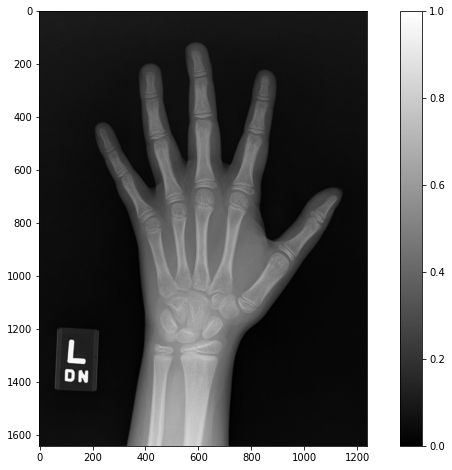

torch.Size([1, 1643, 1237])
Age: 120.0
Sex: 1.0
tensor([[0.1176, 0.1176, 0.1098,  ..., 0.1020, 0.1020, 0.0980],
        [0.1137, 0.1137, 0.1176,  ..., 0.0980, 0.0941, 0.0980],
        [0.1137, 0.1176, 0.1216,  ..., 0.0902, 0.0902, 0.0941],
        ...,
        [0.0588, 0.0627, 0.0588,  ..., 0.0471, 0.0471, 0.0471],
        [0.0549, 0.0588, 0.0549,  ..., 0.0471, 0.0510, 0.0471],
        [0.0510, 0.0549, 0.0549,  ..., 0.0510, 0.0510, 0.0471]])


In [ ]:
#show 2 examples before editing them and print their shapes, age sex
fig = plt.figure(figsize = (12,8))
img, sex, label =train_set[3]
#label = train_label
#sex = test_features[-1]
#img = train_feature[:-1].reshape(shape)
plt.imshow(img[0,:,:], cmap="gray")
plt.colorbar()
plt.show()
print(img.shape)
print(f"Age: {label}")
print(f"Sex: {sex}")
print(img[0,:,:])

## Data Preprocessing

In [ ]:
shape = [224,224]
transformations = tv.transforms.Compose([
                                tv.transforms.ToPILImage(),                                
                                tv.transforms.Resize(223, max_size=224),    
                                tv.transforms.CenterCrop(shape),                       
                                tv.transforms.ToTensor(),
                                tv.transforms.Lambda(lambda img: tc.where(img < img.mean(),tc.zeros(img.shape), img)),
                                ])

train_set.transform = transformations
val1_set.transform = transformations
test_set.transform = transformations

In [ ]:
#show 2 examples before editing them and print their shapes, age sex
fig = plt.figure(figsize = (12,8))
img, sex, label =train_set[381]
#label = train_label
#sex = test_features[-1]
#img = train_feature[:-1].reshape(shape)
plt.imshow(img[0,:,:], cmap="gray")
plt.colorbar()
plt.show()
print(img.shape)
print(f"Age: {label}")
print(f"Sex: {sex}")

## Neural Network Architectures

In [ ]:
class model_name(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x, sex):


## Training

In [ ]:
def train(model, n_epochs, train_loader, val_loader, optimizer,device,
          loss_function=nn.MSELoss(), start_epoch=0, model_name="best_model.pt"):
  
  model.train()
  tc.autograd.set_detect_anomaly(True)
  best_val_loss = float("inf")
  
  train_losses = tc.zeros(n_epochs)
  val_losses = tc.zeros(n_epochs)
  
  
  for epoch in range(start_epoch, n_epochs):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss = evaluate_epoch(model, val_loader, loss_function, device)

    if val_loss < best_val_loss:
      best_val_loss = val_loss

      tc.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss':  train_losses,
          }, model_name)
      
    end_time = time.time()

    # printing
    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}%")
    print(f"Val -- Loss: {val_loss:.3f}%")

    # Save
    train_losses[epoch] = train_loss
    train_accs[epoch] = train_acc
    val_losses[epoch] = val_loss
    val_accs[epoch] = val_acc

  return train_losses, train_accs, val_losses, val_accs

In [ ]:
def train_epoch(model, data_loader, optimizer, loss_function, device):
  model.train()

  epoch_loss = 0
  for img, sex, age in data_loader:

    age = age.float().to(device)
    img = img.to(device)
    sex = sex.to(device)
    loss_function = loss_function.to(device)

    # forward + backward + optimize
    estim_output  = tc.squeeze(model(img, sex))
    batch_loss = loss_function(estim_output, age)
    epoch_loss += batch_loss

    optimizer.zero_grad(set_to_none=True)
    batch_loss.backward()
    optimizer.step()

  return float(epoch_loss.item())/len(data_loader)

In [ ]:
def evaluate_epoch(model, data_loader, loss_function, device):
  model.eval()

  epoch_loss = 0

  with tc.no_grad():
    for img, sex, age in data_loader:
      
      age = age.float().to(device)
      img = img.to(device)
      sex = sex.to(device)
      loss_function = loss_function.to(device)

      # forward
      predictions = tc.squeeze(model(img, sex))
      
      batch_loss = loss_function(predictions, age)
      epoch_loss += batch_loss

  return float(epoch_loss.item())/len(data_loader)

In [ ]:
model = model_name().to(device)
model = nn.DataParallel(model)
optimizer = tc.optim.Adam(model.parameters(), 0.005)
print(summary(model, (1, 224, 224)))

TypeError: ignored

Following cell loads models that already exist, for example to continue training 

In [ ]:
"""model = Alexnet()
model = nn.DataParallel(model)
optimizer = optim.Adam(model.parameters(), lr=0.005,)

checkpoint = tc.load("/content/drive/MyDrive/AlexNet")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']"""

RuntimeError: ignored

In [ ]:
n_epochs = 2000

train_losses, train_accs, val_losses, val_accs = train(model,
                                                       n_epochs,
                                                       train_loader, 
                                                       val_loader, 
                                                       optimizer, 
                                                       device,
                                                       nn.MSELoss(),
                                                       epoch,
                                                       model_name='AlexNet')

## Evaluation

visualize model, print evaluation methods on test set, discuss